# Mini Generative Pretrained Transformer (GPT)

This notebook illustrates a basic implementation of the Generative Pretrained Transformer using PyTorch. We follow a similar approach as described in the original [GPT paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). Further details about the model architecture will be provided in the [Mini GPT Architecture](#mini-gpt) section. The specific section cover in this notebook are:

1. [Data preparation](#data-preparation) 


In [1]:
# black formatting with jupyter-black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=140,
)

<a id='data'></a>
## Data preparation


Wi will use [wikipedia](https://huggingface.co/datasets/bookcorpus/bookcorpus) as data to pre-train our mini-gpt model, this dataset is about 20GB storage so grab a coffee while data is downloaded

In [35]:
# import load_dataset
from datasets import load_dataset

We will not work with the entire dataset as the training may take weeks, so we will work with a portion of the original dataset, feel free to increase or decrease the amount of data used during training. 

In [3]:
# load de dataset
data = load_dataset("wikipedia", "20220301.en", split="train[0:500]", trust_remote_code=True).to_pandas()
# data = load_dataset("karpathy/tiny_shakespeare", split="train", trust_remote_code=True).to_pandas()

In [4]:
# normalizer dataset
from utils import text_preprocessing

data.text = data.text.apply(text_preprocessing)

In [5]:
data.head()

,id,url,title,text
0,12,https://en.wikipedia.org/wiki/Anarchism,Anarchism,anarchism is a political philosophy and moveme...
1,25,https://en.wikipedia.org/wiki/Autism,Autism,autism is a neurodevelopmental disorder charac...
2,39,https://en.wikipedia.org/wiki/Albedo,Albedo,albedo (; ) is the measure of the diffuse refl...
3,290,https://en.wikipedia.org/wiki/A,A,"a, or a, is the first letter and the first vow..."
4,303,https://en.wikipedia.org/wiki/Alabama,Alabama,alabama () is a state in the southeastern regi...


# Tokenizer 

We have implemented a Byte-Per Encoding Tokenizer. However, this python implementation is really slow and so we will use a transformers implementation of Byte-Per Encoding Tokenizer 

In [6]:
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Metaspace, PreTokenizer
import re
import pandas as pd

In [7]:
# Initialize tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))

# setting pre-tokenization to gpt2 tokenizer
tokenizer.pre_tokenizer = Metaspace(replacement="Ñ")

# Initialize a trainer with desired parameters
vocab_size = 30000
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>", "<s>", "</s>"])

# preprocess data
data.text = data.text.apply(text_preprocessing)

# Load your training data into a list of strings
train_data = data.text.tolist()

# Train the tokenizer
tokenizer.train_from_iterator(
    train_data,
    trainer=trainer,
)

In [8]:
tokenizer.encode("praying, she's a good person").tokens

['Ñpray', 'ing,', 'Ñshe', "'s", 'Ña', 'Ñgood', 'Ñperson']

In [9]:
# count number of words
data["text_length"] = data.text.apply(lambda x: len(tokenizer.encode(x).tokens))
# data = data.query("text_length>=5 and text_length<=60").reset_index(drop=True)

<Axes: xlabel='text_length', ylabel='Count'>

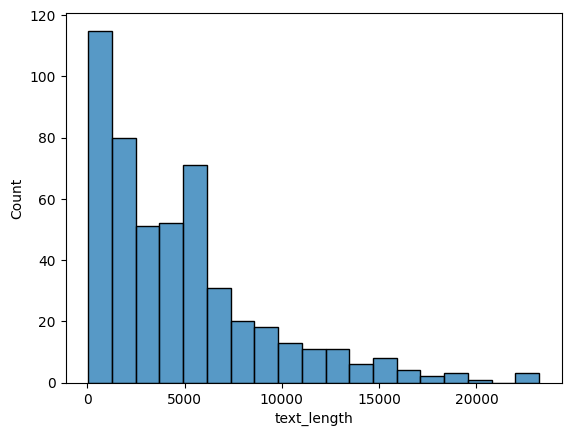

In [10]:
# plot number of words distribution#mini-gpt

sns.histplot(data=data, x="text_length")

## Training Dataset

Here we create a training dataset for causal language modeling

In [11]:
# Define max sequence length
max_seq_len = 128

split_tokens_ids = []
split_tokens = []

# In order to latter add being of sentence token (<s>) and end of sentence token (</s>), we subtract -2 to the max_seq_len
seq_len = max_seq_len - 2

for id in range(len(data)):
    tokens = tokenizer.encode(data.text.tolist()[id]).ids

    for i in range(len(tokens) // seq_len):

        # split
        split_tokens_ids.append(tokenizer.encode("<s>").ids + tokens[i * seq_len : (i + 1) * seq_len] + tokenizer.encode("</s>").ids)

        #
        split_tokens.append(re.sub(r"\s(?!Ñ)", "", tokenizer.decode(split_tokens_ids[i], skip_special_tokens=False)).replace("Ñ", ""))


# Create a pandas dataframe with the text and tokens ids
prepared_data = pd.DataFrame({"text": split_tokens, "tokens": split_tokens_ids})
print(prepared_data.shape)
prepared_data.head(10)

(18644, 2)


,text,tokens
0,<s> anarchism is a political philosophy and mo...,"[1, 6530, 774, 710, 2154, 3271, 740, 2780, 807..."
1,<s>icism toward authority also rose. although ...,"[1, 8690, 2677, 4931, 948, 6823, 18, 1764, 112..."
2,<s> employs a diversity of tactics in order to...,"[1, 19666, 710, 10950, 734, 14346, 736, 1633, ..."
3,"<s> of the prefix an- (""without"") and the word...","[1, 734, 714, 9418, 727, 17, 2659, 6274, 1035,..."
4,<s> first political philosopher to call himsel...,"[1, 998, 2154, 2797, 748, 1266, 2461, 727, 730..."
5,"<s> a vanguard party, and extreme cultural lib...","[1, 710, 796, 1206, 892, 9581, 740, 4806, 3044..."
6,<s> to the state is central to anarchist thoug...,"[1, 748, 714, 1284, 774, 2126, 748, 7302, 1452..."
7,<s>ed as a reaction. the most notable precurso...,"[1, 726, 770, 710, 19237, 714, 1054, 4621, 226..."
8,<s> dismissed human law (nomos) and associated...,"[1, 12280, 1706, 1513, 2400, 760, 17258, 740, ..."
9,<s> in private judgment during the reformation...,"[1, 736, 3570, 11824, 1222, 714, 14603, 9097, ..."


## Create Custom Dataset and Data Collator

Here we define our custom dataloader

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        tokens_ids = self.data.tokens.iloc[idx]
        tokens_ids = torch.LongTensor(tokens_ids)

        return tokens_ids

In [14]:
def data_collator_for_clm(batch):

    tokens_ids = torch.stack(batch)
    attention_mask = torch.tril(torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1])).bool()

    return tokens_ids, attention_mask

In [15]:
ds = CustomDataset(prepared_data)
data_loader = DataLoader(ds, batch_size=2, collate_fn=data_collator_for_clm)

In [16]:
token_ids, attention_mask = next(iter(data_loader))

In [17]:
token_ids.shape

torch.Size([2, 128])

In [18]:
attention_mask.shape

torch.Size([2, 1, 128, 128])

## Mini GPT

For this implementation we will implement a architecture similar to the one proposed in the [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) original paper

<img src="https://i.imgur.com/lgoqvjZ.png" alt= “” width="300px" height="500px">

In [19]:
from utils import DecoderTransformer
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [20]:
class MiniGPT(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, pf_dim, vocab_size, max_seq_length, n_layers, device="cpu") -> None:
        super().__init__()

        self.max_seq_length = max_seq_length

        self.decoder = DecoderTransformer(embed_dim, num_heads, dropout, pf_dim, vocab_size, max_seq_length, n_layers, device)
        self.output = torch.nn.Linear(embed_dim, vocab_size, bias=False).to(device)
        self.device = device

    def forward(self, x, mask):

        # x shape: (batch_size, max_seq_length)
        # mask shape: (batch_size, 1, max_seq_length, max_seq_length)

        x = self.decoder(x, mask)  # x shape (batch_size, max_seq_length, embedding_dim)
        x = self.output(x)  # x shape: (batch_size, max_seq_length, vocab_size)

        return x

    def config_training_args(self, lr=2.5e-4, weight_decay=0.1, scheduler=None, scheduler_kwargs={}, gradient_accumulation=1):

        self.gradient_accumulation = gradient_accumulation

        grouped_params = self.get_grouped_params(weight_decay=weight_decay)
        self.optimizer = torch.optim.AdamW(grouped_params, lr=lr)
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=0.1)

        self.scheduler = scheduler(self.optimizer, **scheduler_kwargs)

    def get_grouped_params(self, weight_decay=0.1):

        no_decay = ["bias", "layer_norm.weight", "embedding"]
        params_with_wd, params_without_wd = [], []

        for name, weight in self.named_parameters():

            if any([nd in name for nd in no_decay]):
                params_without_wd.append(weight)
            else:
                params_with_wd.append(weight)

        return [{"params": params_with_wd, "weight_decay": weight_decay}, {"params": params_without_wd, "weight_decay": 0}]

    def train_one_epoch(self, train_dataloader):

        running_loss = 0.0

        bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)

        # set zero grad
        self.optimizer.zero_grad()

        for step, (token_ids, attention_mask) in enumerate(bar, 1):

            # move to the correct device
            token_ids, attention_mask = token_ids.to(self.device), attention_mask.to(self.device)

            # forward pass
            outputs = self(token_ids, attention_mask)

            # remove begin of sentence token from labels
            labels = token_ids[:, 1:]

            # remove end_of_sentence token from outputs
            outputs = outputs[:, :-1, :]

            # reshape outputs and labels
            labels = labels.reshape(-1)
            outputs = outputs.reshape(-1, outputs.shape[2])

            # compute loss
            loss = F.cross_entropy(outputs, labels) / self.gradient_accumulation

            # backward pass
            loss.backward()

            # apply gradient accumulation
            if step % self.gradient_accumulation == 0:

                # apply gradient clipping
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

                # update weights
                self.optimizer.step()

                # apply scheduler
                if self.scheduler is not None:
                    self.scheduler.step()

                # set zero grad
                self.optimizer.zero_grad()

            # running loss
            running_loss += loss.item() * self.gradient_accumulation

            # print statistics
            bar.set_description(f"Train loss: {running_loss/step:.5f}")

    def train(self, train_dataloader, epochs):

        bar = tqdm(range(1, epochs + 1), total=epochs, leave=True)

        for epoch in bar:

            self.train_one_epoch(train_dataloader)
            bar.set_description(f"Epoch {epoch}/{epochs}")

    @torch.no_grad()
    def generate(self, sentence, tokenizer, temperature):

        sentence = "<s> " + sentence

        tokens_ids = torch.LongTensor(tokenizer.encode(sentence).ids).unsqueeze(0).to("cuda")
        attention_mask = torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1]).bool().to("cuda")

        for _ in range(tokens_ids.shape[-1], self.max_seq_length):

            # compute logits
            logits = self(tokens_ids, attention_mask)

            # scale logits with temperature
            logits = logits[:, -1, :] / temperature

            # computes probabilities
            probs = F.softmax(logits, dim=-1)

            # sample new token using a multinomial distribution
            new_token = torch.multinomial(probs, 1)

            # update tokens ids with the new predicted token
            tokens_ids = torch.cat((tokens_ids, new_token), dim=-1)

            # updates the attention mask
            attention_mask = torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1]).bool().to("cuda")

            if new_token == tokenizer.encode("</s>").ids[0]:
                break

        prediction = tokens_ids.cpu().squeeze(0).tolist()
        prediction = re.sub(r"\s(?!Ñ)", "", tokenizer.decode(prediction, skip_special_tokens=False)).replace("Ñ", "")

        return prediction

In [21]:
# Test the DecoderTransformer layer
embed_dim = 768
num_heads = 12
dropout = 0.1
pf_dim = 3072
bs = 32
n_layers = 12
n_epochs = 5

gpt = MiniGPT(
    embed_dim=embed_dim,
    num_heads=num_heads,
    dropout=dropout,
    pf_dim=pf_dim,
    vocab_size=vocab_size,
    max_seq_length=max_seq_len,
    n_layers=n_layers,
    device="cuda",
)

In [22]:
ds = CustomDataset(prepared_data)
data_loader = DataLoader(ds, batch_size=bs, collate_fn=data_collator_for_clm, shuffle=True)

In [23]:
# confing model training args
gradient_accumulation = 8
lr = 2.5e-4
weight_decay = 0.1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": len(data_loader) * n_epochs // gradient_accumulation, "eta_min": 1e-6}


gpt.config_training_args(lr, weight_decay, scheduler, scheduler_kwargs, gradient_accumulation)

In [25]:
gpt.train(data_loader, epochs=n_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

In [34]:
gpt.generate("anarchism is a political philosophy and", tokenizer, temperature=0.8)

'<s> anarchism is a political philosophy and platform, james the congress to ised lake flav and isitus, and mut-of its  that medieval until and his he the to is the for hisin the anglican in this and ) – were () the –  he original a the and copper a of and setting of the the of an sodium than cognitive role the them sixth such the as food and (" of a: with as play ) thea. to and, of appeared on of in these of the northern notes-m . the the average who  of of  aachen a each the and person thisd) (d. ut up and the in of the track</s>'